# NLP501 – Exercise 1: Sentiment Analysis & Vector Spaces

### Deliverables

- This notebook contains **Part 1 (Sentiment Classification)**, **Part 2 (Word Vectors & Similarity)**, and **Part 3 (Document Search)**.
- Dataset choices follow the project requirements.

**Rules respected:**

- Only allowed libraries: `numpy`, `pandas`, `sklearn`, `nltk`, `gensim` (no pre-trained embeddings for Part 2).
- Train/Test split 80/20.
- Compare at least 2 feature extraction methods.
- Provide metrics + confusion matrix + error analysis.
- Build co-occurrence vectors + PCA + cosine similarity + analogy tests.
- Implement TF-IDF document search with cosine ranking and a simple interface.




In [ ]:
# =========================
# 0) Setup
# =========================
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("✅ Libraries imported. Seed set to", SEED)


✅ Libraries imported. Seed set to 42


---

# Part 1 — Sentiment Classification (40%)

I build a binary sentiment classifier (**positive/negative**) using:

- **Two feature extraction methods**: Bag-of-Words (Count) and TF-IDF
- **Two models** (extra creativity point): Logistic Regression and Multinomial Naive Bayes

I then compare results, show confusion matrix, and analyze common errors.

Dataset: **IMDB movie reviews** from NLTK (widely used, clean binary labels).


In [ ]:
# =========================
# 1.1) Load IMDB dataset (NLTK)
# =========================
import nltk
from nltk.corpus import movie_reviews

# Download once (safe to run multiple times)
nltk.download('movie_reviews')

docs = []
labels = []

for fileid in movie_reviews.fileids():
    label = movie_reviews.categories(fileid)[0]  # 'pos' or 'neg'
    text = movie_reviews.raw(fileid)
    docs.append(text)
    labels.append(1 if label == 'pos' else 0)

df = pd.DataFrame({'text': docs, 'label': labels})
df['label_name'] = df['label'].map({1: 'pos', 0: 'neg'})
df.head()


[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


,text,label,label_name
0,"plot : two teen couples go to a church party ,...",0,neg
1,the happy bastard's quick movie review \ndamn ...,0,neg
2,it is movies like these that make a jaded movi...,0,neg
3,""" quest for camelot "" is warner bros . ' firs...",0,neg
4,synopsis : a mentally unstable man undergoing ...,0,neg


In [ ]:
# Quick dataset stats
print("Total samples:", len(df))
print(df['label_name'].value_counts())


Total samples: 2000
label_name
neg    1000
pos    1000
Name: count, dtype: int64


## 1.2 Text preprocessing

Required steps: **lowercase**, **remove punctuation**, **tokenization**.

I Will implement a light preprocessing function:

- Lowercase
- Replace non-letter characters with space
- Collapse multiple spaces

This keeps things simple and reproducible.


In [ ]:
def preprocess_text(text: str) -> str:
    text = text.lower()
    # Keep letters and spaces
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


df['clean_text'] = df['text'].apply(preprocess_text)
df[['text', 'clean_text', 'label_name']].head()


,text,clean_text,label_name
0,"plot : two teen couples go to a church party ,...",plot two teen couples go to a church party dri...,neg
1,the happy bastard's quick movie review \ndamn ...,the happy bastard s quick movie review damn th...,neg
2,it is movies like these that make a jaded movi...,it is movies like these that make a jaded movi...,neg
3,""" quest for camelot "" is warner bros . ' firs...",quest for camelot is warner bros first feature...,neg
4,synopsis : a mentally unstable man undergoing ...,synopsis a mentally unstable man undergoing ps...,neg


In [ ]:
# Train-test split (80/20) as required
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=SEED, stratify=df['label']
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("Class balance (train):")
print(pd.Series(y_train).value_counts(normalize=True))


Train size: 1600
Test size: 400
Class balance (train):
label
1    0.5
0    0.5
Name: proportion, dtype: float64


## 1.3 Feature extraction: Count vs TF-IDF

I am compare:

1. **CountVectorizer** (word frequency)
2. **TfidfVectorizer** (TF-IDF)

Extra improvement (creativity): I am using **bigrams** `(1,2)` to capture phrases like `not good`.


In [ ]:
# Vectorizers
count_vec = CountVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.95)
tfidf_vec = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.95)

X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)

X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

print("Count features:", X_train_count.shape)
print("TF-IDF features:", X_train_tfidf.shape)


Count features: (1600, 115822)
TF-IDF features: (1600, 115822)


## 1.4 Training & evaluation helper


In [ ]:
def evaluate_model(model, Xtr, Xte, ytr, yte, name="model"):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    p, r, f1, _ = precision_recall_fscore_support(
        yte, pred, average='binary', zero_division=0)
    cm = confusion_matrix(yte, pred)
    return {
        "name": name,
        "accuracy": acc,
        "precision": p,
        "recall": r,
        "f1": f1,
        "cm": cm,
        "pred": pred,
        "model": model
    }


def pretty_metrics(result):
    return pd.Series({
        "Accuracy": result["accuracy"],
        "Precision": result["precision"],
        "Recall": result["recall"],
        "F1-score": result["f1"]
    })


## 1.5 Train 2 models × 2 vectorizers (bonus)

Required: Logistic Regression **or** Naive Bayes.
I do both for a stronger report (and creativity point).


In [ ]:
lr = LogisticRegression(max_iter=2000, random_state=SEED)
nb = MultinomialNB()

results = []
results.append(evaluate_model(lr, X_train_count, X_test_count,
               y_train, y_test, name="LR + Count(1,2)"))
results.append(evaluate_model(lr, X_train_tfidf, X_test_tfidf,
               y_train, y_test, name="LR + TFIDF(1,2)"))
results.append(evaluate_model(nb, X_train_count, X_test_count,
               y_train, y_test, name="NB + Count(1,2)"))
results.append(evaluate_model(nb, X_train_tfidf, X_test_tfidf,
               y_train, y_test, name="NB + TFIDF(1,2)"))

metrics_df = pd.DataFrame([pretty_metrics(r)
                          for r in results], index=[r["name"] for r in results])
metrics_df.sort_values("F1-score", ascending=False)


,Accuracy,Precision,Recall,F1-score
"LR + Count(1,2)",0.8525,0.854271,0.850,0.852130
"NB + TFIDF(1,2)",0.8350,0.816038,0.865,0.839806
"LR + TFIDF(1,2)",0.8375,0.829268,0.850,0.839506
"NB + Count(1,2)",0.8250,0.812500,0.845,0.828431


## 1.6 Confusion matrix + error analysis

I pick the **best model by F1** and analyze:

- False Positives (pred pos, true neg)
- False Negatives (pred neg, true pos)

I also print sample misclassified reviews to discuss why they failed (negation, sarcasm, mixed sentiment).


🏆 Best model: LR + Count(1,2)
Confusion Matrix: [[171  29]
 [ 30 170]]


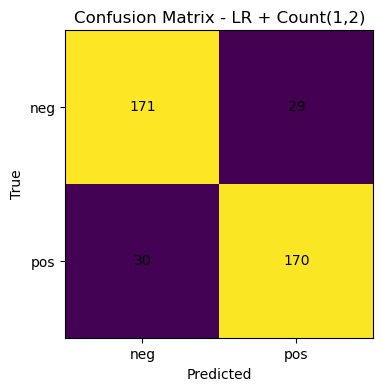


Classification report:

              precision    recall  f1-score   support

         neg       0.85      0.85      0.85       200
         pos       0.85      0.85      0.85       200

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400



In [ ]:
best = sorted(results, key=lambda x: x["f1"], reverse=True)[0]
best_name = best["name"]
best_cm = best["cm"]
best_pred = best["pred"]

print("🏆 Best model:", best_name)
print("Confusion Matrix:", best_cm)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(best_cm)
plt.title(f"Confusion Matrix - {best_name}")
plt.xticks([0, 1], ["neg", "pos"])
plt.yticks([0, 1], ["neg", "pos"])
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, best_cm[i, j], ha='center', va='center')
plt.show()

print("\nClassification report:\n")
print(classification_report(y_test, best_pred, target_names=["neg", "pos"]))


In [ ]:
# Error analysis: show a few FP/FN examples
X_test_list = list(X_test)
y_test_list = list(y_test)

fp_idx = [i for i, (yt, yp) in enumerate(
    zip(y_test_list, best_pred)) if yt == 0 and yp == 1]
fn_idx = [i for i, (yt, yp) in enumerate(
    zip(y_test_list, best_pred)) if yt == 1 and yp == 0]

print("False Positives:", len(fp_idx))
print("False Negatives:", len(fn_idx))


def show_examples(indices, title, k=3):
    print("\n" + "="*70)
    print(title)
    print("="*70)
    for i in indices[:k]:
        snippet = X_test_list[i][:300].replace("\n", " ")
        print(f"Index {i} | True={y_test_list[i]} Pred={best_pred[i]}")
        print("Text:", snippet, "...")
        print("-"*70)


show_examples(fp_idx, "Examples of False Positives (pred pos, true neg)", k=3)
show_examples(fn_idx, "Examples of False Negatives (pred neg, true pos)", k=3)


False Positives: 29
False Negatives: 30

Examples of False Positives (pred pos, true neg)
Index 10 | True=0 Pred=1
Text: in the line of duty is the critically praised series of television movies dealing with the real life incidents that claimed lives of law enforcement officers in usa the twilight murders another one from the series is dealing with the case of gordon kahl played by rod steiger old farmer from north da ...
----------------------------------------------------------------------
Index 14 | True=0 Pred=1
Text: according to popular film opinion a film s greatness is determined by time take for example casablanca great film even today it s still as powerful as it was when it came out and still as romantic and tragic another example would be star wars which had a very very healthy box office gross despite th ...
----------------------------------------------------------------------
Index 44 | True=0 Pred=1
Text: mandingo has traditionally been seen as one of two things either 

---

# Part 2 — Word Vectors & Similarity (30%)

I **build word vectors from scratch** using a **co-occurrence matrix** (no pre-trained embeddings).

Steps:

1. Build a vocabulary of top-N words
2. Build co-occurrence counts within a context window
3. Convert into word vectors
4. PCA reduce to 50D (then 2D for visualization)
5. Cosine similarity + nearest neighbors
6. Word analogy tests (>=10)


In [ ]:
# =========================
# 2.1) Build corpus tokens from training data
# =========================
from collections import Counter, defaultdict


def tokenize(text: str):
    return text.split()


train_tokens = [tokenize(t) for t in X_train]  # tokenized reviews
all_tokens = [tok for doc in train_tokens for tok in doc]

# Limit vocab size for speed
VOCAB_SIZE = 4000
counts = Counter(all_tokens)
most_common = counts.most_common(VOCAB_SIZE)
vocab = {w: i for i, (w, c) in enumerate(most_common)}
id2word = {i: w for w, i in vocab.items()}

print("Vocab size:", len(vocab))
print("Top 10 words:", list(vocab.keys())[:10])


Vocab size: 4000
Top 10 words: ['the', 'a', 'and', 'of', 'to', 'is', 'in', 's', 'it', 'that']


In [ ]:
# =========================
# 2.2) Build co-occurrence matrix
# =========================
WINDOW_SIZE = 4

# sparse counting via dict of dict, then convert to dense (VOCAB_SIZE small enough)
cooc = np.zeros((VOCAB_SIZE, VOCAB_SIZE), dtype=np.float32)

for doc in train_tokens:
    doc_ids = [vocab[w] for w in doc if w in vocab]
    for i, center in enumerate(doc_ids):
        start = max(0, i - WINDOW_SIZE)
        end = min(len(doc_ids), i + WINDOW_SIZE + 1)
        for j in range(start, end):
            if i == j:
                continue
            context = doc_ids[j]
            cooc[center, context] += 1.0

print("Co-occurrence matrix shape:", cooc.shape)
print("Non-zero entries:", int(np.count_nonzero(cooc)))


Co-occurrence matrix shape: (4000, 4000)
Non-zero entries: 1460320


## 2.3 Normalize vectors (PMI-like weighting - bonus)

Raw co-occurrence can be dominated by frequent words.
A simple improvement is **Positive PMI (PPMI)** weighting.
This is optional but earns quality/creativity points.



In [ ]:
# =========================
# 2.3) Compute PPMI matrix (optional improvement)
# =========================
eps = 1e-8
total = np.sum(cooc)
Pw = np.sum(cooc, axis=1) / (total + eps)
Pc = np.sum(cooc, axis=0) / (total + eps)
Pwc = cooc / (total + eps)

ppmi = np.maximum(0, np.log((Pwc + eps) / (Pw[:, None] * Pc[None, :] + eps)))

print("PPMI matrix computed. Shape:", ppmi.shape)


PPMI matrix computed. Shape: (4000, 4000)


In [ ]:
# =========================
# 2.4) PCA reduce to 50D and 2D
# =========================
pca50 = PCA(n_components=50, random_state=SEED)
vec50 = pca50.fit_transform(ppmi)

pca2 = PCA(n_components=2, random_state=SEED)
vec2 = pca2.fit_transform(vec50)

print("vec50 shape:", vec50.shape, "vec2 shape:", vec2.shape)


vec50 shape: (4000, 50) vec2 shape: (4000, 2)


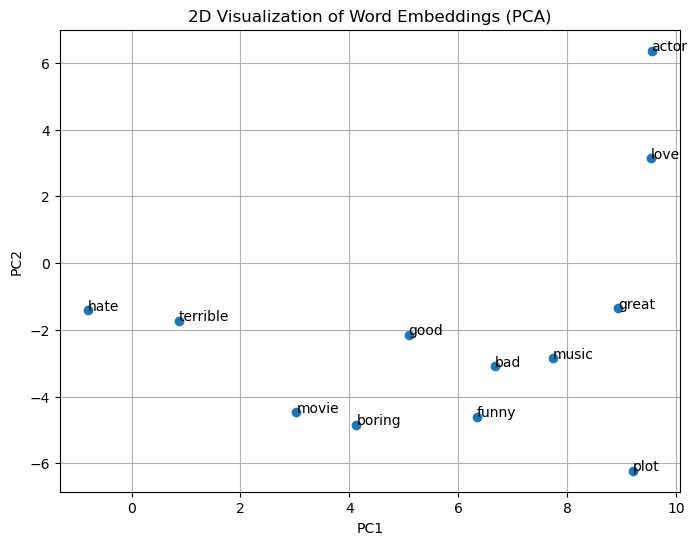

In [ ]:
# =========================
# 2.5) Visualize embeddings (2D)
# =========================
# Pick some interesting words to plot
plot_words = ["good", "bad", "great", "terrible", "love",
              "hate", "funny", "boring", "movie", "plot", "actor", "music"]
plot_ids = [vocab[w] for w in plot_words if w in vocab]

plt.figure(figsize=(8, 6))
plt.scatter(vec2[plot_ids, 0], vec2[plot_ids, 1])

for wid in plot_ids:
    plt.text(vec2[wid, 0], vec2[wid, 1], id2word[wid])

plt.title("2D Visualization of Word Embeddings (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


## 2.6 Cosine similarity + nearest neighbors


In [ ]:
def cosine_sim(word1, word2, vecs=vec50):
    if word1 not in vocab or word2 not in vocab:
        return None
    v1 = vecs[vocab[word1]]
    v2 = vecs[vocab[word2]]
    return float(np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2) + 1e-9))


pairs = [("good", "great"), ("good", "bad"), ("love", "hate"),
         ("funny", "boring"), ("movie", "film")]
for a, b in pairs:
    sim = cosine_sim(a, b)
    print(f"cosine({a},{b}) = {sim:.4f}")


cosine(good,great) = 0.7139
cosine(good,bad) = 0.7490
cosine(love,hate) = 0.0705
cosine(funny,boring) = 0.5310
cosine(movie,film) = 0.7457


In [ ]:
def nearest_neighbors(word, top_k=10, vecs=vec50):
    if word not in vocab:
        return []
    wv = vecs[vocab[word]].reshape(1, -1)
    sims = cosine_similarity(wv, vecs)[0]
    best_ids = np.argsort(-sims)[:top_k+1]  # include itself
    out = [(id2word[i], float(sims[i]))
           for i in best_ids if id2word[i] != word][:top_k]
    return out


print("Nearest neighbors for 'good':")
nearest_neighbors("good", top_k=10)


Nearest neighbors for 'good':


[('well', 0.8130781650543213),
 ('here', 0.7782130241394043),
 ('does', 0.7581580877304077),
 ('but', 0.7550944089889526),
 ('isn', 0.7508003115653992),
 ('bad', 0.7490056753158569),
 ('very', 0.7423251867294312),
 ('better', 0.7344970703125),
 ('great', 0.7138776779174805),
 ('also', 0.7075167894363403)]

## 2.7 Word analogy tests (>=10)

I test analogies using:
\[
b - a + c \approx d
\]
I will try at least 10 analogies. Some may fail depending on corpus domain (IMDB), and that's OK as long as we analyze it.


In [ ]:
def analogy(a, b, c, top_k=5, vecs=vec50):
    # b - a + c
    for w in [a, b, c]:
        if w not in vocab:
            return []
    target = vecs[vocab[b]] - vecs[vocab[a]] + vecs[vocab[c]]
    sims = cosine_similarity(target.reshape(1, -1), vecs)[0]
    # exclude input words
    for w in [a, b, c]:
        sims[vocab[w]] = -1e9
    best = np.argsort(-sims)[:top_k]
    return [(id2word[i], float(sims[i])) for i in best]


analogy_tests = [
    ("bad", "good", "terrible"),
    ("bad", "good", "awful"),
    ("boring", "funny", "dull"),
    ("hate", "love", "like"),
    ("worst", "best", "great"),
    ("poor", "excellent", "good"),
    ("disappointing", "amazing", "great"),
    ("slow", "fast", "quick"),
    ("sad", "happy", "joy"),
    ("negative", "positive", "good"),
]

for a, b, c in analogy_tests:
    print(f"Analogy: {b} - {a} + {c} ≈ ?")
    print(analogy(a, b, c, top_k=5))
    print("-"*60)


Analogy: good - bad + terrible ≈ ?
[('outstanding', 0.5797078609466553), ('impressive', 0.5748956203460693), ('performances', 0.5595740675926208), ('realistic', 0.5555270910263062), ('solid', 0.5498166680335999)]
------------------------------------------------------------
Analogy: good - bad + awful ≈ ?
[('adequate', 0.6224936246871948), ('ensemble', 0.6015645861625671), ('notch', 0.5961568355560303), ('impressive', 0.5959814786911011), ('solid', 0.587605893611908)]
------------------------------------------------------------
Analogy: funny - boring + dull ≈ ?
[('enjoyable', 0.6737799048423767), ('humorous', 0.6040644645690918), ('clever', 0.5824614763259888), ('particularly', 0.5819864273071289), ('witty', 0.5785347819328308)]
------------------------------------------------------------
Analogy: love - hate + like ≈ ?
[('with', 0.7823141813278198), ('man', 0.7622735500335693), ('however', 0.7567881941795349), ('while', 0.734372615814209), ('being', 0.7213739156723022)]
--------------

---

# Part 3 — Document Search (30%)

I implement a simple search engine using **TF-IDF + cosine similarity**.

Dataset: **20 Newsgroups** (recommended by project).
I build:

- TF-IDF vectors for documents
- `search(query)` ranking by cosine similarity
- Notebook interface with sample queries and inspection


In [ ]:
# =========================
# 3.1) Load 20 Newsgroups dataset
# =========================
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(
    subset='all', remove=('headers', 'footers', 'quotes'))
docs = newsgroups.data
targets = newsgroups.target
target_names = newsgroups.target_names

print("Total documents:", len(docs))
print("Number of categories:", len(target_names))
print("Example category:", target_names[targets[0]])
print("Snippet:", docs[0][:200].replace("\n", " "), "...")


Total documents: 18846
Number of categories: 20
Example category: rec.sport.hockey
Snippet:   I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am  bit puzzled too and a bit relieved. However, ...


In [ ]:
# =========================
# 3.2) TF-IDF vectorization
# =========================
doc_tfidf = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.9)
X_docs = doc_tfidf.fit_transform(docs)
print("TF-IDF matrix shape:", X_docs.shape)


TF-IDF matrix shape: (18846, 51840)


In [ ]:
# =========================
# 3.3) Search function (cosine similarity)
# =========================
def search(query, top_k=5):
    q = preprocess_text(query)
    q_vec = doc_tfidf.transform([q])
    sims = cosine_similarity(q_vec, X_docs)[0]
    top_idx = np.argsort(-sims)[:top_k]
    results = []
    for idx in top_idx:
        results.append({
            "rank": len(results)+1,
            "score": float(sims[idx]),
            "category": target_names[targets[idx]],
            "snippet": docs[idx][:220].replace("\n", " ")
        })
    return pd.DataFrame(results)


# Simple interface demo
search("space shuttle launch nasa", top_k=5)


,rank,score,category,snippet
0,1,0.459634,sci.space,Archive-name: space/schedule Last-modified: $D...
1,2,0.446517,sci.space,Archive-name: space/addresses Last-modified: $...
2,3,0.436716,sci.space,Archive-name: space/net Last-modified: $Date: ...
3,4,0.436502,sci.space,Archive-name: space/controversy Last-modified:...
4,5,0.434827,sci.space,Sorry for asking a question that's not entirel...


In [ ]:
# =========================
# 3.4) Evaluate with sample queries
# =========================
queries = [
    "space mission nasa shuttle",
    "graphics card image rendering",
    "guns control law weapons",
    "christian religion bible church",
    "hockey game nhl season",
]

for q in queries:
    print("\nQuery:", q)
    display(search(q, top_k=3))



Query: space mission nasa shuttle


,rank,score,category,snippet
0,1,0.435678,sci.space,Archive-name: space/addresses Last-modified: $...
1,2,0.426768,sci.space,Archive-name: space/schedule Last-modified: $D...
2,3,0.416881,sci.space,Archive-name: space/controversy Last-modified:...



Query: graphics card image rendering


,rank,score,category,snippet
0,1,0.456531,comp.graphics,Yes. There are many methods of rendering...
1,2,0.381926,comp.graphics,"Does anyone truely understand the ""INVALID NOR..."
2,3,0.300336,comp.graphics,I am happy to announce the first public releas...



Query: guns control law weapons


,rank,score,category,snippet
0,1,0.451451,talk.politics.guns,Gun clubs: If you are a member you CAN borrow ...
1,2,0.306632,talk.politics.guns,I hope you realize how trivial it is to man...
2,3,0.306625,talk.politics.guns,"Here is a letter I sent to David Skaggs, (Dem,..."



Query: christian religion bible church


,rank,score,category,snippet
0,1,0.511376,soc.religion.christian,"Hi, I don't know much about Bible. Could you ..."
1,2,0.396594,alt.atheism,no its not. its due to the fact that there a...
2,3,0.386672,soc.religion.christian,"A ""new Christian"" wrote that he was new to the..."



Query: hockey game nhl season


,rank,score,category,snippet
0,1,0.427740,rec.sport.hockey,"But only in NY,NJ, Philadelphia, and Chicago...."
1,2,0.421791,rec.sport.hockey,Archive-name: hockey-faq rec.sport.hockey ans...
2,3,0.394157,rec.sport.hockey,"Well, as a hockey fan, I think it's terrible..."
